In [2]:
import qiskit

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Paste your API key and CRN here
your_api_key = "m4pXf0-RYR9LzNsjpeV-4mmBQWyz7zSHZABCMCeiO_rW"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/9f4b3ecfcd974fbc81f65360c96af934:563f335d-6fcb-425e-9c2b-7e88c6b7ef08::"   # CRN example: 'ibm-q/open/main' or your assigned CRN

# Save your IBM Quantum Platform account (new upgraded system)
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",    # You can change this label if needed
    overwrite=True
)
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
  # Avoids full backend listing
service.saved_accounts()

{'default-ibm-cloud': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'w562J-5MW-NNn7U7nY6fDEGDo1PVG4Jr6fXceiU9sO5aw562J-5MW-NNn7U7nY6fDEGDo1PVG4Jr6fXceiU9sO5a',
  'verify': True,
  'private_endpoint': False},
 'default-ibm-quantum': {'channel': 'ibm_quantum',
  'url': 'https://auth.quantum.ibm.com/api',
  'token': 'i9p3I9Li196K0HO92ku4d4DEpNafO6L_-kMzhYCaOHY0',
  'verify': True,
  'private_endpoint': False},
 'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'm4pXf0-RYR9LzNsjpeV-4mmBQWyz7zSHZABCMCeiO_rW',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/9f4b3ecfcd974fbc81f65360c96af934:563f335d-6fcb-425e-9c2b-7e88c6b7ef08::',
  'verify': True,
  'private_endpoint': False}}

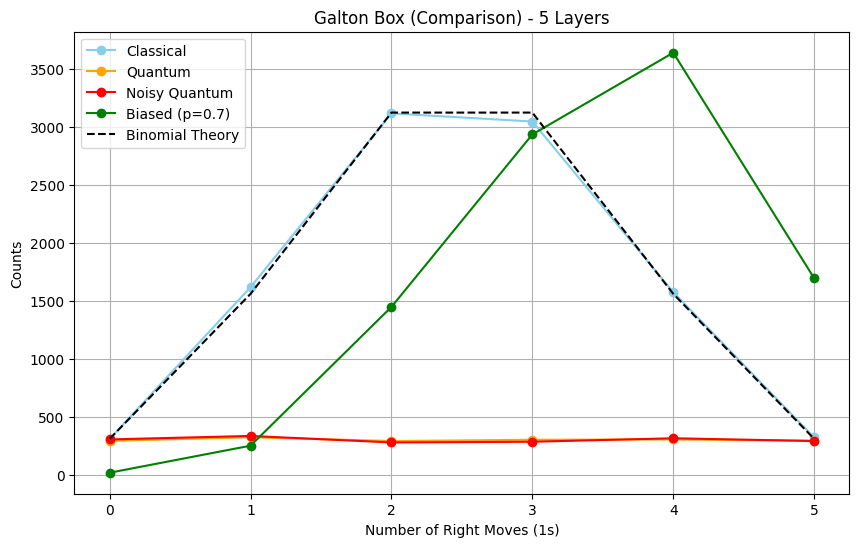

🔹 Classical:
   • TVD: 0.0000
   • KL Divergence: 0.0000

🔹 Quantum:
   • TVD: 0.2887
   • KL Divergence: 0.2594

🔹 Noisy Quantum:
   • TVD: 0.3048
   • KL Divergence: 0.2791

🔹 Biased (p=0.7):
   • TVD: 0.3436
   • KL Divergence: 0.4487



In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import binom, entropy
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# ---------- Parameters ----------
shots = 10000
n_layers = 5
bias = 0.7
result_dir = "results/5_layers"
os.makedirs(result_dir, exist_ok=True)

# ---------- Classical Galton Box ----------
def classical_galton_box(n, shots):
    outcomes = [sum(random.choices([0, 1], k=n)) for _ in range(shots)]
    return Counter(outcomes)

# ---------- Biased Galton Box ----------
def biased_galton_box(n, shots, p):
    outcomes = [sum(random.choices([0, 1], weights=[1-p, p], k=n)) for _ in range(shots)]
    return Counter(outcomes)

# ---------- Quantum Galton Box ----------
def quantum_galton_box(n, shots):
    qc = QuantumCircuit(n, n)
    for i in range(n):
        qc.h(i)
    qc.measure(range(n), range(n))

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    return Counter({bit.count('1'): count for bit, count in counts.items()})

# ---------- Noisy Quantum Galton Box ----------
def noisy_quantum_box(n, shots):
    qc = QuantumCircuit(n, n)
    for i in range(n):
        qc.h(i)
    qc.measure(range(n), range(n))

    # Noise Model (depolarizing error)
    noise_model = NoiseModel()
    error = depolarizing_error(0.05, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h'])

    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    return Counter({bit.count('1'): count for bit, count in counts.items()})

# ---------- Metric Functions ----------
def normalize(counter):
    total = sum(counter.values())
    return np.array([counter.get(k, 0) / total for k in range(n_layers + 1)])

def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def kl(p, q):
    p_safe = np.where(p == 0, 1e-10, p)
    q_safe = np.where(q == 0, 1e-10, q)
    return entropy(p_safe, q_safe)

# ---------- Run ----------
results = {
    "Classical": classical_galton_box(n_layers, shots),
    "Quantum": quantum_galton_box(n_layers, shots),
    "Noisy Quantum": noisy_quantum_box(n_layers, shots),
    "Biased (p=0.7)": biased_galton_box(n_layers, shots, bias),
}

# ---------- Plot ----------
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'red', 'green']

for idx, (label, data) in enumerate(results.items()):
    keys = sorted(data.keys())
    values = [data.get(k, 0) for k in range(n_layers + 1)]
    plt.plot(keys, values, marker='o', linestyle='-', label=label, color=colors[idx])

# Add Binomial Theory
x = np.arange(n_layers + 1)
theory = binom.pmf(x, n_layers, 0.5) * shots
plt.plot(x, theory, 'k--', label='Binomial Theory')

plt.xlabel("Number of Right Moves (1s)")
plt.ylabel("Counts")
plt.title(f"Galton Box (Comparison) - {n_layers} Layers")
plt.legend()
plt.grid(True)

save_path = os.path.join(result_dir, f"galton_box_comparison_{n_layers}_layers.png")
plt.savefig(save_path)
plt.show()

# ---------- Print Metrics ----------
ref = normalize(results["Classical"])
for method, data in results.items():
    dist = normalize(data)
    print(f"🔹 {method}:")
    print(f"   • TVD: {tvd(ref, dist):.4f}")
    print(f"   • KL Divergence: {kl(ref, dist):.4f}")
    print()



